In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline

In [87]:
class RectangleMesh():
    def __init__(self, point_1, point_2, nx, ny):
        self.num_nodes = (nx+1)*(ny+1)
        self.num_ele = (nx)*(ny)
        self.geomtery = self.create_geometry(point_1, point_2, nx, ny)
        self.topology = self.create_topology(nx,ny)
    
    def create_geometry(self, point_1, point_2, nx, ny):
        """ This method will return the node_number vs
        co-ordinate table. The node numbering is done left
        to right, bottom to top.
        """
        geo = np.zeros((self.num_nodes,2))
        x = np.linspace(point_1[0],point_2[0],nx+1)
        y = np.linspace(point_1[1],point_2[1],ny+1)
        xx, yy = np.meshgrid(x, y)
        geo[:,0] = xx.reshape(self.num_nodes) 
        geo[:,1] = yy.reshape(self.num_nodes)
        return geo
    def create_topology(self, nx, ny):
        """
        This method will create the connectivity table.
        The element number is done left to right, bottom to top.
        """
        topo = np.zeros((self.num_ele, 4)).astype(int)
        for i in range(ny):
            for j in range(nx):
                ele_num = nx*(i)+j
                topo[ele_num,:] = [ele_num+i,ele_num+i+1,ele_num+i+nx+2,ele_num+i+nx+1]
        return topo
    def plot(self):
        for i in range(self.num_ele):
            p = Polygon(self.geomtery[np.ix_(self.topology[i])], fc='white',ec="black",lw=3)
            plt.gca().add_patch(p)
        plt.axis('scaled')
        plt.show()


In [96]:
mesh = RectangleMesh([0, 0], [1, 1], 3, 3)

In [97]:
mesh.geomtery[np.ix_(mesh.topology[0])][0]

array([0., 0.])

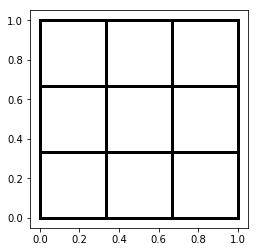

In [98]:
mesh.plot()